## <center>Reduction of NIRSPAO Spectra (SPEC Images) of NGC 253</center>
------
### Reduction steps: 
__1) Make bias frame, flat field & its corresponding median dark, along with dark-subtracted, flat-fielded arc lamp frame & $A-B$ cal star frames__

__2) Generate reduced arc lamp image (dark-subtracted, flat-fielded) used in rectification__

__3) Generate reduced but unrectified cal star $A-B$ image: identify $ABBA$ frames, clean cosmic rays, $A-B$ subtract, flat-field__

__4) Reduce object (O) images: identify & clean sky (S) images, clean object image & match to sky image, $O-S$ subtraction, flat-field__

__5) Rectify object image, cal star image.__  Spatial & spectral rectification using arc & cal star frames as spatial & spectral traces, calculate wavelength solution, & apply to calibration star image & science image.


__Note__: consider switching step 5) to step 3), doing rectification _before_ flat-fielding



---

In [1]:
#%matplotlib notebook
import matplotlib, pylab, os, astropy
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['figure.dpi'] = 200
# matplotlib.rcParams['figure.autolayout']=True
# matplotlib.rcParams['figure.figsize']=[8.0,6.0]
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')

from astropy.io import fits,ascii
from astropy.table import Table,QTable
from astropy.io import ascii
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel,interpolate_replace_nans,convolve
from astropy.stats import mad_std,sigma_clipped_stats,SigmaClip
from astropy.visualization import ImageNormalize, AsinhStretch, SqrtStretch, MinMaxInterval, ZScaleInterval
from astropy.nddata import CCDData
from astropy.time import Time
from regions import read_ds9

import ccdproc as ccdp

from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from photutils import CircularAperture
from photutils import DAOStarFinder,Background2D,MedianBackground

from regions import PixCoord,RectanglePixelRegion,write_ds9
# from drizzlepac import tweakreg
# from stsci.stimage import xyxymatch

#from tweakwcs.matchutils import MatchCatalogs,TPMatch
# from tweakwcs.linearfit import iter_linear_fit

from pyraf import iraf


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Define paths for raw data

In [2]:


# Define raw image directory, list of raw SCAM files corresponding to sky (off-target) images, \
# & list of raw SCAM science files 
path='/Users/dcohen/RESEARCH/NGC253_NIRSPAO/KOA_26773/NIRSPEC/2019aug14/raw/spec/'
pathrot='/Users/dcohen/RESEARCH/NGC253_NIRSPAO/KOA_26773/NIRSPEC/2019aug14/raw/spec/rotated/'
pre='nspec190814_'

# Organize file lists
reddir='/Users/dcohen/RESEARCH/NGC253_NIRSPAO/Reduction/'
caldir='cal/' # will save reduction files into caldir/spec/
objdir='n253/' # ' ' n253/spec/
stddir='std/' # st&ard star files,' ' std/spec


#~~ Calib files & images

# Rectification : Spatial spat.map & spectral spec.map
#flatframes=['0007','0008','0009','0010']

# Flats & corresponding darks
#biasframes=['0006']
# flatframes=['0008','0009','0010']  # 11-21 as well?
# flatframes+=['00%i'%n for n in range(11,22)]
# darkframes=['00%i'%n for n in range(22,32)] # darks s0022-s0031, exp time = 8.85s

overscanreg="[6:2042,2046:2048]" 
trimsec="[6:2042,6:2042]"
# flatframes = glob(path+'rot/flats/'+pre+'*.fits')
# darkframes = glob(path+'rot/darks/'+pre+'*.fits')
      
# # Arc(s) & corresponding dark
# # arcframes = glob(path+'rot/arcs10s/all_10s.fits')
# arcframes = glob(path+'rot/arcs150s/all_150s.fits')
# adarkframes = glob(path+'rot/arcs150s/dark_150s.fits')
# # adarkframes = glob(path+'rot/darks/*.fits')
# #

# Cal star (standard star)
# stdframes= ['0049','0050','0051','0052'] # id of ABBA sequence frames, or AB if only two
# # stdframes=[]
# # [stdframes.append( glob(path+'rot/'+pre+'*%s.fits'%i)[0] ) for i in stdABBAid]

# # Object (science) & sky (background) frames
# skyframes=['0057','0062']

# sciframes=['00%i'%n for n in list(range(53,57,1))+list(range(58,62,1))+list(range(63,70,1))]
# print(sciframes)
# objframes=[glob(path+'rot/'+pre+'*%s.fits'%n)[0] for n in objid]
# skyframes=[glob(path+'rot/'+pre+'*%s.fits'%n)[0] for n in skyid] 

# #~~ check number of files in each frame type
# for f in (flatframes,darkframes,arcframes,adarkframes,stdframes,objframes,skyframes):
#     if np.size(f)==0:
#         print("NO FILES FOUND FOR FRAME TYPE")
        
        
    

### Functions for: rectification, flat normalization, calculating the noise image, spatial and spectral rectification, converting wavelength grid to velocity in the heliocentric frame

In [47]:
#%matplotlib notebook
import matplotlib, pylab, os, astropy, copy
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['figure.dpi'] = 200
# matplotlib.rcParams['figure.autolayout']=True
# matplotlib.rcParams['figure.figsize']=[8.0,6.0]
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')

from scipy import ndimage as nd
from scipy import interpolate
import scipy.signal as signal
from scipy.signal import argrelextrema,find_peaks,windows
from astropy.stats import sigma_clip
import numpy.fft as fft
from astropy.io import ascii,fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.stats import mad_std,sigma_clipped_stats,SigmaClip
from astropy.visualization import ImageNormalize, AsinhStretch, SqrtStretch, MinMaxInterval, ZScaleInterval
from astropy.time import Time
from astropy.convolution import Gaussian2DKernel,Box2DKernel,interpolate_replace_nans,convolve
from astropy.modeling import models, fitting
from astropy.coordinates import EarthLocation
from astropy.table import Table,QTable
from astropy.coordinates import SkyCoord
from regions import read_ds9,write_ds9
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import noise_region_uncertainty,snr_threshold

from photutils import DAOStarFinder,Background2D,MedianBackground,CircularAperture
from astroscrappy import detect_cosmics


import ccdproc as ccdp

from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from photutils import CircularAperture
from photutils import DAOStarFinder,Background2D,MedianBackground

# clean hot/cold pixels from data using astroscrappy.detect_cosmics
def cosmic_clean(data,maxiter=4,sigclip=4.5,sigfrac=0.2,objlim=5.0,mask=None,satlvl=65000.,gain=1.0,rdnoise=10.8):
    """
    cleaned_data, bad_mask = cosmic_clean(data,mask=None,...) where ... are optional arguments for detect_cosmics
    
    """
    crmask,cleandata=detect_cosmics(data, inmask=mask, sigclip=sigclip, sigfrac=sigfrac, objlim=objlim, gain=gain,\
                                   readnoise=rdnoise, satlevel=satlvl, niter=maxiter, sepmed=True, \
                                   cleantype='medmask', fsmode='median') 
    return cleandata, crmask


def noise_img(objdata, flatdata, t_int, gain=2.85, rdnoise=10.8, darkcur=0.67 ):
    """
    flat is expected to be normalized and both obj and flat are expected to be rectified
    """    
    # calculate photon noise
    noisedata = objdata / gain
    
    # add read noise
    noisedata += (rdnoise / gain)**2
    
    # add dark current noise
    noisedata += (darkcur / gain) * t_int
    
    # divide by normalized flat squared
    noisedata /= flatdata**2
    
    return noisedata


def sub_poly(data,mask=None,order=[2,2]):
    """
    Fit and subtract 2D polynomial to data with x/y fit order set by `order'. 
    Used to model and subtract background, such as scattered light between echelle orders.
    
    `mask' should have value 1 for pixels to be fit, and 0 for pixels excluded from fit.
    """
    y, x = np.meshgrid(np.arange(data.shape[0]),np.arange(data.shape[1]))#[:data.shape[0], :data.shape[1]]
    p_init = models.Legendre2D(2,2)
    fit_p = fitting.LinearLSQFitter()#LevMarLSQFitter()
    p = fit_p(p_init, x[np.where(mask==0.0)], y[np.where(mask==0.0)], data[np.where(mask==0.0)])
    residual=data-p(x,y)
    return residual,p(x,y)


def sub_bkg(data,mask=None,boxsize=[1,1]):
    """
    Calculate and subtract 2D background using `photutils.Background2D'. 
    `boxsize' should have type int, or tuple/list with two ints, and is the fractional size of characteristic background 
    relative to the image size in the 0th, 1st dimensions (y, x). `boxsize=[4,3]' means the background is 1/4th, 1/3rd 
    the size of the 0th and 1st image dimensions, respectively.
    
    data_sub, background = sub_bkg(data,mask=None,boxsize=[4, 4])
    """
    bkg=Background2D(data,boxsize,mask=mask,\
            sigma_clip=SigmaClip(sigma=2.5,maxiters=3,cenfunc=np.nanmedian,stdfunc=np.nanstd))
    
    return data-bkg.background, bkg.background

def normalize_flat(data, mask):
    """
    data is 2D spectrum, either rectified or non-rectified
    ordermask is a numpy array w same shape as data, with 1s within the order and 0s outside the order 

    returns normalized data array and mean of the on-order pixels
    """
    # make off-order mask
   # offmask=1-mask
    
    # include negative and saturated pixels
    #coldhotmask=(data<=lothresh)|(data>=hithresh)
    #pixmask=offmask.astype(np.bool) | coldhotmask.astype(np.bool)
    
    # count pixels in / outside of order
    non = np.count_nonzero(mask)
    noff = np.count_nonzero(1-mask)

    #if np.count_nonzero(mask) == 0:
    #    return

   # # ignore pixels beyond column 1000 by setting value to 1.0
   # data_copy[:, 1000:] = 1.0

    # take mean of only the on-order pixels
    mean = np.ma.masked_array(data, mask=1-mask).mean()
    
    # create normalized data array
    normalized = data * mask / mean

    # around the edges of the order can blow up when div by mean, set those to one
    normalized[np.where(normalized > 10.0)] = 1

    # avoid zeroes (not to sure about these)
    normalized[np.where(normalized == 0.0)] = 1
    normalized[np.where(normalized < 0.2)] = 1
    
    # and set masked pixels to have value 1
    normalized[np.where(mask==0)] = 1
    
   # normalized[np.where(coldhotmask.astype(int)==1)]=1
    
    # calculate mean of new masked image
   # nmask=normalized==1.0
   # maskmean=np.ma.masked_array(data,mask=(nmask|coldhotmask)).median()
   # ndata=data/maskmean
   # ndata[np.where(nmask==1.0)]=1.0
    
    return normalized, mean

def read_spatmap(file):
    
    fo=open(file,'r')
    head=fo.readline().split()
    fo.close()
    ncoeff=int(head[0])
    ncol=int(head[1])
    rowbot=int(head[2])
    rowtop=int(head[3])
    nrow=rowtop-rowbot
    shiftmid=float(head[4])
    shiftdelta=float(head[5])
    row=np.arange(nrow)+1.0
    
    spat=np.loadtxt(file,skiprows=1)
    #print(spat[:5,:])
    col=spat[:,0]
    coeff=spat[:,1:]
    
    curve=np.zeros([col.size])
    for i in range(col.size):
      #  [print(ncoeff-p) for p in range(ncoeff+1)]
        p=np.poly1d(coeff[i,:])
        curve[i]=p(i+0.5)
    
    return curve,col,coeff,rowbot,rowtop,shiftmid,shiftdelta

def read_specmap(file):
    fo=open(file,'r')
    head=fo.readline().split()
    fo.close()
    ncoeff=int(head[0])
    ncol=int(head[1])
    rowbot=int(head[2])
    rowtop=int(head[3])
    nrow=rowtop-rowbot
    wavemid=float(head[4])
    wavedelta=float(head[5])
    #print(nrow)
    specmap=np.loadtxt(file,skiprows=1)
    row=specmap[:,0]
    coeff=specmap[:,1:]
    
    curve=np.zeros([row.size])
    #print(curve.shape)
    for j in range(row.size):
        s=np.array([coeff[j,p] * (j+0.5)**p for p in range(ncoeff+1)]).sum()
        curve[j]=s
    
    return curve,row,coeff,rowbot,rowtop,wavemid,wavedelta
    

def rectify_spatial(data, curve):
    """
    Shift data, column by column, along y-axis according to curve.
    
    Returns shifted image.
    
    Throws IndexError exception if length of curve 
    is not equal to number of columns in data. 
    """
    
    # shift curve to be centered at middle of order 
    # and change sign so shift is corrective
    #curve_p = 1.0 * (curve + (data.shape[0] / 2))
    curve_p = -1.0 * curve
    curve_p = curve - np.amin(curve)

    rectified = []
    for i in range(0, len(curve_p)):
        s = data[:,i]
        rectified.append(ndimage.interpolation.shift(
                s, curve_p[i], order=3, mode='nearest', prefilter=True))
        
    return np.array(rectified).T


def rectify_spectral(data, curve):
    """
    Shift data, row by row, along x-axis according to curve.
    
    Returns shifted image.
    
    Throws IndexError exception if length of curve
    is not equal to number of rows in data.
    """
    
    # pivot curve around peak 
    # and change sign so shift is corrective
    profile = data.sum(axis=1)
    peak = np.argmax(profile)
    curve_p = -1.0 * (curve - curve[peak])
        
    rectified = []
    for i in range(0, len(curve_p)):
        s = data[i, :]
        rectified.append(ndimage.interpolation.shift(
                s, curve_p[i], order=3, mode='nearest', prefilter=True))  
    
    return(np.array(rectified))



def spatrect(data,spatfile):

    """ 
        Perform spatial rectification on NIRSPEC spectrum.
    
        data -- should be 2D numpy array, i.e. the un-rectified spectrum read into python with astropy.io
        spatfile -- Spatmap file, e.g. 'spat.map'
    
    """
    
   # if rotate:
   #     data=np.rot90(data,-1)
    
    # Read parameters and spatial map.
    fo=open(spatfile,'r')
    recfitorder,xdim,clip_ya,clip_yb,wavecntr,wavedelta=fo.readline().split()
    fo.close()
    recfitorder=int(recfitorder)
    xdim=int(xdim)
    clip_ya=int(clip_ya)
    clip_yb=int(clip_yb)
 #   dataclip=data[clip_ya:clip_yb+1,:]
    wavecntr=float(wavecntr)
    wavedelta=float(wavedelta)
    ydim=clip_yb-clip_ya+1
    wavemin=wavecntr-(ydim/2.)*wavedelta
    spatmap=np.loadtxt(spatfile,skiprows=1,usecols=range(1,recfitorder+2))
    dataclip=data[clip_ya:clip_yb+1,:]
   # print(dataclip.shape)
    
    rectified=np.zeros([ydim,xdim])
    shifts=np.zeros([ydim,xdim])

    #~ Interpol
    for i in range(xdim):
        wavein=np.zeros(ydim)
        waveinb=np.zeros(ydim+1)
        
        for k in np.arange(0,recfitorder+1):
            wavein=wavein+spatmap[i,k]*np.arange(ydim)**k
            waveinb=waveinb+spatmap[i,k]*(np.arange(ydim+1)-0.5)**k
        #print(wavein.shape,datain.shape)
        waveout=wavemin+wavedelta*(np.arange(ydim)+0.5)
        
        datain=dataclip[:,i]
        
        func_interp=interpolate.interp1d(wavein,datain,kind='quadratic',fill_value='extrapolate',assume_sorted=False)
        dataout=func_interp(waveout)
        shifts[:,i]=waveout-wavein
        dout_din=wavedelta/(waveinb[1:]-waveinb[:-1])
       # print(dataout.shape)
        rectified[:,i]=dataout#*dout_din#*dout_din
        
    return rectified,waveout
        
def specrect(data,specfile):

    """ 
        Perform spatial rectification on NIRSPEC spectrum.
    
        data -- should be 2D numpy array, i.e. the un-rectified spectrum read into python with astropy.io
        spatfile -- Spatmap file, e.g. 'spat.map'
    
    """
    # Read parameters and spatial map.
    fo=open(specfile,'r')
    recfitorder,xdim,clip_ya,clip_yb,wavecntr,wavedelta=fo.readline().split()
    fo.close()
    recfitorder=int(recfitorder)
    xdim=int(xdim)
    clip_ya=int(clip_ya)
    clip_yb=int(clip_yb)
 #   dataclip=data[clip_ya:clip_yb+1,:]
    wavecntr=float(wavecntr)
    wavedelta=float(wavedelta)
    ydim=clip_yb-clip_ya+1
    wavemin=wavecntr-(xdim/2.)*wavedelta
    specmap=np.loadtxt(specfile,skiprows=1,usecols=range(1,recfitorder+2))
   # dataclip=data[clip_ya:clip_yb+1,:]
   # print(dataclip.shape)
    
    rectified=np.zeros([ydim,xdim])
    shifts=np.zeros([ydim,xdim])

    #~ Interpol
    for j in range(ydim):
        wavein=np.zeros(xdim)
        waveinb=np.zeros(xdim+1)
        
        for k in np.arange(0,recfitorder+1):
            wavein=wavein+specmap[j,k]*np.arange(xdim)**k
            waveinb=waveinb+specmap[j,k]*(np.arange(xdim+1)-0.5)**k
        #print(wavein.shape,datain.shape)
        waveout=wavemin+wavedelta*(np.arange(xdim)+0.5)
        
        datain=data[j,:]
        
        func_interp=interpolate.interp1d(wavein,datain,kind='quadratic',fill_value='extrapolate',assume_sorted=False)
        dataout=func_interp(waveout)
        shifts[j,:]=waveout-wavein
        dout_din=wavedelta/(waveinb[1:]-waveinb[:-1])
       # print(dataout.shape)
        rectified[j,:]=dataout#*dout_din#*dout_din
        
    return rectified,waveout

def rectify(data,spatfile,specfile,mask=None):
    
   # data=hdu.data
    if type(mask)==np.ndarray:
        dataspat,sx=spatrect(np.ma.masked_array(data,mask=mask),spatfile)
    else:
        dataspat,sx=spatrect(data,spatfile)
    datarect,wavearr=specrect(dataspat,specfile)
    ydim,xdim=datarect.shape
    
    
#     hduout=fits.PrimaryHDU(data=datarect,header=hdu.header)
    
#     if update_hdr:
#         try:
#             del hduout.header['CD1_1']
#             del hduout.header['CD1_2']
#             del hduout.header['CD2_2']
#             del hduout.header['CD2_1']
#         except:
#             print('')
        
#         fields=['CTYPE1','CRPIX1','CRVAL1','CDELT1','CUNIT1',\
#                'CTYPE2','CRPIX2','CRVAL2','CDELT2','CUNIT2']
#         values=['WAVE',xdim//2,wavearr[(xdim//2) - 1],wavearr[1]-wavearr[0],'um',\
#              'OFFSET',ydim//2,0.,0.0085,'arcsec']
#         for f,v in zip(fields,values):
          
#             try:
#                 del hduout.header[f]
#             except:
#                 print('')
#             hduout.header.set(f,v) 
        
    
    return datarect,wavearr


def fringe(y,filt=None,medwidth=51,freqlo=40,freqhi=130,thresh_peak=5,plot=True):
    
    """ 
        Remove fringe patterns in 1D spectrum using Hanning filter in FFT domain.
        Subtract a smoothed spectrum (median filter width = filtwidth), compute FFT,
        and remove the freqs in power spectrum corresponding to fringing.
    
    """
    
    #~~ name parameters that don't change throughout procedure
    xdim = y.size
    xpix=np.arange(xdim)+1
    #print("X-dim: ",xpix.size)
    xdimfft=300
    nfilt=xdim//2+1
    freq=np.arange(nfilt)
  #  print(nfil)
    specorig = copy.copy(y)
    specmed = np.median(specorig)
    specsmooth = signal.medfilt(specorig,medwidth) # yields different result than IDL median
    specfft = fft.fft(specorig-specsmooth)#specsmooth)
    if type(filt)==type(None): # if the hann filter is not given as an input,
        #print("Filtering row")
        freq = fft.fftfreq(specfft.size,d=1.0/float(xdim))
        yp = np.abs( specfft[2:nfilt] )**2
        yprms = np.std(yp)
        ipeaks,prop=signal.find_peaks(yp/yprms,treshold=0.5height=thresh_peak,distance=2)
        widths=signal.peak_widths(yp/yprms,ipeaks,rel_height=1.0)
        fpeaks=freq[2:nfilt][ipeaks]
        flo=fpeaks-widths[0]/2.
        fhi=fpeaks+widths[0]/2.
        heights=prop['peak_heights']

        if plot:
            fig = plt.figure()
            ax1=fig.add_subplot(111)

    # plot power spectrum and intensity
            ax1.plot(freq[2:nfilt],yp/yprms,'k-',lw=2)
            ax1.bar(fpeaks,heights,width=widths[0],align='center',facecolor='red',edgecolor='red',alpha=0.9)
       # ax1.vlines(fpeaks,np.zeros(ypeaks.size),ypeaks,color='red',alpha=1.0,linewidth=2.0)
            ax1.set_xlim(0,xdimfft)
            ax1.set_xlabel("Frequency [1/2048 pix]")
            ax1.set_ylabel("Power")
            ax1.annotate("Power Spectrum",xy=(0.75,0.75),xycoords=('axes fraction'))    
            plt.show()
    
    #freq=np.arange( nfilt/2 + 1, dtype='float' ) / ( nfilt / float(xdim) )
    #print(freq.size)
    #filtstack=np.zeros([ipeaks.size,freq.size])
    
    
        filt=np.ones(freq.size)
        for p in range(ipeaks.size):
       # print(flo[p],fhi[p])
            filt*=((freq<flo[p]) | (freq>fhi[p])).astype('float')
       # print(np.any(filt>1.))
        filt = np.concatenate((filt,np.fliplr(filt[1:])))
        filt = np.real(fft.ifft(filt))
        filt = filt/nfilt
        filt = np.roll(filt,nfilt//2)
        #filt = filt*np.hanning(filt.size) 
        filt = filt*windows.hamming(filt.size) #np.hanning(filt.size) 
        ycorr = nd.filters.convolve(specorig-specsmooth, filt, mode='wrap') + specsmooth
        
        return ycorr,filt.copy()
        
    elif type(filt)==np.ndarray:
        #print("")
        
        ycorr = nd.filters.convolve(specorig-specsmooth, filt, mode='wrap') + specsmooth
        
        return ycorr

    
#~~
def fringe2D(data,medwidth=51,thresh_peak=5.0,correct_each_row=False):

    """
        Remove fringe patterns in 1D spectrum using Hanning filter in FFT domain.
        Subtract a smoothed spectrum (median filter width = filtwidth), compute FFT,
        and remove the freqs in power spectrum corresponding to fringing.

    """

    #~~ name parameters that don't change throughout procedure
    xdim = data.shape[1]
    ydim = data.shape[0]
    corr = np.zeros([ydim,xdim])
    # start by performing 1D fringe correction on collapsed spectrum to get hanning filter, use buffer of 20 pix 
    # from edges
    if correct_each_row: # then use different filter for each row of data
        print("Filtering each row independently")
    # loop through rows of echellogram and apply fringe correction to each on
        for i in range(ydim):
            ci,fi = fringe(data[i,:],medwidth=medwidth,filt=None,\
                thresh_peak=thresh_peak,plot=False)
            corr[i,:] += ci
            
    elif correct_each_row==False: # apply identical filter to each row, calculated from collapsed 1D spectrum 
        print("Filtering rows with single filter")
        yc,hfilt=fringe(np.mean(data[6:-6,:],0),medwidth=medwidth,filt=None,\
                thresh_peak=thresh_peak,plot=True)
        
        # loop through rows of echellogram and apply fringe correction to each on
        for i in range(ydim):
            ci = fringe(data[i,:],filt=hfilt,medwidth=medwidth,\
                thresh_peak=thresh_peak,plot=False)
            corr[i,:] += ci
           # corr[i,:]=rowcorr
        #print(type(filt))
        
    else:
        print("Invalid input for option `correct_each_row`, should be boolean.")
        
        
    return corr


def reduce_flat(flatframes,darkframes,outflat="Flat.fits",outdark="Dark.fits",\
                clean=True,dark_subtract=True,flat_normalize=True,ordermask=None):
    """
    flatframes (list of str) - Python list containing filenames of all flat-field images 
    darkframes (str) - Filename of dark frame with same exposure time as flats
    """

    # Make combined dark frame for flat
    darksreduced=[] # to be list of reduced flat images
    #darkbpmasks=[]
  #  darknums=[] # to be list of frame numbers, read from fits header
    print("Cleaning and combining dark frames...")
    for frame in darkframes:
        
        # read data
        hdu=fits.open(frame)[0]
        dat=hdu.data
        hdr=hdu.header
        
        # make copy
        datcopy=dat.copy()
        hdrcopy=hdr.copy()
        
        # clean bad pixels
        if clean:
            print("Cleaning bad pixels from frame: %s"%hdrcopy['ofname'])
            datred,bpm=cosmic_clean(datcopy)
        else:
            datred=datcopy
            bpm=np.zeros(datcopy.shape)
            bpm[np.where((datcopy <= 0.) | (datcopy >= 25000.))]=1

        datred[np.where(bpm==True)]=np.nan
        kern=Box2DKernel(6)
        datred=interpolate_replace_nans(datred,kern)
        # append reduced data to list of reduced flats
        darksreduced.append(datred)
       # darkbpmasks.append(bpm)

    #    darknums.append(flathdr['ofname'][-9:-5])
    # combine and save fits image
    darkcomb=np.mean(darksreduced,axis=0) 
    print("Cleaning hot/cold pixels in combined dark image and saving image as %s..."%outdark)
    #darkout=cleanpix(darkcomb.data,iternum=3)
    
    fits.writeto(outdark,data=darkcomb,overwrite=True)
    
    # Make combined flat
    flatsreduced=[] # to be list of reduced flat images
  #  flatbpmasks=[]
    #flatnums=[] # to be list of frame numbers, read from fits header
    print("Reducing and combining flat frames...")
    for frame in flatframes:
        # read data
        hdu=fits.open(frame)[0]
        dat=hdu.data
        hdr=hdu.header
        
        # make copy
        datcopy=dat.copy()
        hdrcopy=hdr.copy()
        
        # clean bad pixels
        if clean:
            print("Cleaning bad pixels from frame: %s"%hdrcopy['ofname'])
            datred,bpm=cosmic_clean(datcopy,sigfrac=0.5)
           # datcopy
        else:
            datred=datcopy
            bpm=np.zeros(datcopy.shape)
            bpm[np.where((datcopy <= 0.) | (datcopy >= 25000.))]=1

        datred[np.where(bpm==True)]=np.nan
        kern=Box2DKernel(6)
        datred=interpolate_replace_nans(datred,kern)  
        if dark_subtract:
            datred-=darkcomb
        flatsreduced.append(datred)
        # subtract dark frame
        #if dark_subtract:
        #    print("Subtracting dark...")
        #    datcopy=datcopy-darkcomb.data
        
        # append reduced data to list of reduced flats
        #flatbpmasks.append(bpm)
    #flatsreduced.append(np.ma.masked_array(datcopy,mask=bpm))
       # flatnums.append(hdrcopy['ofname'][-9:-5])

    # combine, masking bad pixels
    flatcomb=np.median(flatsreduced,axis=0)
        # save dark-subtracted flat
    fits.writeto(outflat,data=flatcomb,overwrite=True)
    # Normalize?
    if flat_normalize:
        print("Normalizing flat...")
        flatnorm,flatscale=normalize(flatcomb,ordermask)
        fits.writeto("/".join(outflat.split('/')[:-1])+"/"+"N"+outflat.split('/')[-1],\
                         data=flatnorm,overwrite=True)


    return 


# 
def reduce_obj(onimage,offimage,flatimage,response,outname='tar',clean=True,norm_hdr_key='elaptime',flatten=True,\
                    rectify_image=True, bkg_subtract=True, fringe_corr=False, spatmap='spat.map',specmap='spec.map',\
               bkg_boxsize=(1,1), filt_width=101, fringe_thresh=2.5  ):
    
    # read .fits inputs as image hdus
    a_hdu=fits.open(onimage)[0]
    b_hdu=fits.open(offimage)[0]
    flat=fits.getdata(flatimage)[0]
    
    # make order mask using master flat (masked where value=1)
    flatmask=flat.astype(int)==1
    #offorder=flat==1
    
    a=a_hdu.data.copy()
    b=b_hdu.data.copy()
    
    #clean cosmic rays
#    kern=Box2DKernel(6)
#     if clean:
#         print("Cleaning cosmic rays...")
#         a,amask=cosmic_clean(a,maxiter=3,objlim=5.0,sigfrac=0.5,sigclip=4.0)
#         b,bmask=cosmic_clean(b,maxiter=3,objlim=5.0,sigfrac=0.5,sigclip=4.0)
#         a[np.where(amask==True)]=np.nan
#         b[np.where(bmask==True)]=np.nan
#         a=interpolate_replace_nans(a,kern)
#         b=interpolate_replace_nans(b,kern)
#     else:
#         amask=np.zeros(a.shape)
#         bmask=np.zeros(b.shape)
        
    #if type(norm_hdr_key)==str:
    #    print("Normalizing by %s"%norm_hdr_key)
    #    a=a/float(a_hdu.header[norm_hdr_key])
        #a[np.where(amask==1)]=0
    #    b=b/float(b_hdu.header[norm_hdr_key])
        #b[np.where(bmask==1)]=0
    #else:
    #    print("ERROR: normalization header keyword should be a valid string. Skipping normalization.")
        
        
    # subtract
    if flatten:
        print("Subtracting image pair and dividing by flat...")
        reduced=(a-b)/flat
    
    else:
        reduced=a-b
        print("Subtracting image pair...")
        
#     if rotated:
#         reduced=np.rot90(reduced,-1)
    if clean:
        reduced,bpmask=cosmic_clean(reduced,maxiter=4,objlim=5.0,sigfrac=0.5,sigclip=4.0)
        reduced=interpolate_replace_nans(reduced,BoxKernel2D(6))
    # initialize output image header
    hdrnow=a_hdu.header.copy()
    
    # rectify
    if rectify_image:
        print("Rectifying in spatial and spectral dimensions...")
        rectified,wavegrid=rectify(reduced,spatmap,specmap)
        
    
        # update header w wavelength info
        print("Updating fits header...")
        ydim,xdim=rectified.shape
        try:
            del hdrnow['CD1_1']
            del hdrnow['CD1_2']
            del hdrnow['CD2_2']
            del hdrnow['CD2_1']
        except:
            print('')
        
        fields=['CTYPE1','CRPIX1','CRVAL1','CDELT1','CUNIT1',\
        'CTYPE2','CRPIX2','CRVAL2','CDELT2','CUNIT2','RESTWAV']
        values=['WAVE',xdim//2,wavegrid[(xdim//2) - 1],wavegrid[1]-wavegrid[0],'um',\
        'OFFSET',ydim//2,0.,hdrnow['pscale'],'arcsec',4.052262e-6]
        
        for f,v in zip(fields,values):
            
            try:
                del hdrnow[f]
            except:
                    print('')
            
            hdrnow.set(f,v)
            
        
        fits.writeto(outname+".fits",data=rectified,header=hdrnow,overwrite=True)
        
        datanow=rectified

    else:

        fits.writeto(outname+".fits",data=reduced,header=hdrnow,overwrite=True)
        
        datanow=reduced


        
    # final clean hot/cold pixels, do no matter what
    #datclean,bpm=cosmic_clean(hduout.data,maxiter=3,objlim=5.0,sigfrac=1.0,sigclip=5.0)
        
    # subtract residual background?
    if bkg_subtract:
#         print("Subtracting residual median background...")
#         mean,med,std=sigma_clipped_stats(hduout.data[statbox[2]:statbox[3],statbox[0]:statbox[1]],sigma=3.0,\
#                                         cenfunc=np.nanmedian, stdfunc=np.nanstd)
        print("Subtracting residual median background...")
     
        bkg=Background2D(datanow,[datanow.shape[0]//bkg_boxsize[0],datanow.shape[1]//bkg_boxsize[1]],\
             sigma_clip=SigmaClip(sigma=3.0,maxiters=2,cenfunc=np.nanmedian,stdfunc=np.nanstd))  
        
        fits.writeto(outname+".bgsub.fits",data=datanow-bkg.background,header=hdrnow,overwrite=True)
        
        datanow=datanow-bkg.background


    if fringe_corr:
        
        datafringe=fringe2D(datanow,medwidth=filt_width,correct_each_row=False,thresh_peak=fringe_thresh)
        
        fits.writeto(outname+".fringe.fits",data=datafringe,header=hdrnow,overwrite=True)
        
        datanow=datafringe

    
    return fits.PrimaryHDU(datanow,hdrnow)


    
def heliocorr(targ,obstime,observatory='Keck'):
    
    #obstime = Time('2017-2-14')
    target = SkyCoord.from_name(targ)  
    loc = EarthLocation.of_site(observatory)  
    corr=target.radial_velocity_correction('heliocentric',obstime=obstime, location=loc).to('km/s')  
    return corr

---
### Define flats, darks, arcs, cal star, science object, and sky image file collections according to fits headers
---

In [ ]:
# make master image collection containing all raw spec data
#rawic=ccdp.ImageFileCollection(path,glob_include=pre+'*.fits')

In [4]:
rawic=ccdp.ImageFileCollection(pathrot,glob_include=pre+'*.fits')

In [5]:
# make masks to group images by type
# flat-fields
flats=(rawic.summary['halogen'] == 'On') & (rawic.summary['neon'] == 'Off') & (rawic.summary['argon'] == 'Off') & \
(rawic.summary['krypton'] == 'Off') & (rawic.summary['xenon'] == 'Off') & \
(rawic.summary['calmpos'] == 'In')
# dark exposures
darks = (rawic.summary['halogen'] == 'Off') & (rawic.summary['neon'] == 'Off') & (rawic.summary['argon'] == 'Off') & \
(rawic.summary['krypton'] == 'Off') & (rawic.summary['xenon'] == 'Off') & \
(rawic.summary['calmpos'] == 'In')
# arc-lamp spectra
arcs = (rawic.summary['halogen'] == 'Off') & ( (rawic.summary['neon'] == 'On') | (rawic.summary['argon'] == 'On') | \
(rawic.summary['krypton'] == 'On') | (rawic.summary['xenon'] == 'On') )& \
(rawic.summary['calmpos'] == 'In')
# calibration/standard stars (HD3604 and HD225200)
stdstar1 = (rawic.summary['object'] == ' HD225200')
stdstar2 = (rawic.summary['object'] == ' HD3604')
# science object (NGC 253) and sky frames
obj= (rawic.summary['object'] == ' N253') | (rawic.summary['object'] == ' N253 TH2')
sky= (rawic.summary['object'] == ' Sky')
#

# Define file lists
path=pathrot
darkfiles=[path+f for f in rawic.summary['file'][darks]]
flatfiles=[path+f for f in rawic.summary['file'][flats]]
arcfiles=[path+f for f in rawic.summary['file'][arcs]]
std1files=[path+f for f in rawic.summary['file'][stdstar1]]
std2files=[path+f for f in rawic.summary['file'][stdstar2]]
objfiles=[path+f for f in rawic.summary['file'][obj]]
skyfiles=[path+f for f in rawic.summary['file'][sky]]

# Define image file collections (ccdproc)
flatic = ccdp.ImageFileCollection(filenames=flatfiles)
darkic = ccdp.ImageFileCollection(filenames=darkfiles)
arcic= ccdp.ImageFileCollection(filenames=arcfiles)
std1ic=ccdp.ImageFileCollection(filenames=std1files)
std2ic=ccdp.ImageFileCollection(filenames=std2files)
objic=ccdp.ImageFileCollection(filenames=objfiles)
skyic=ccdp.ImageFileCollection(filenames=skyfiles)


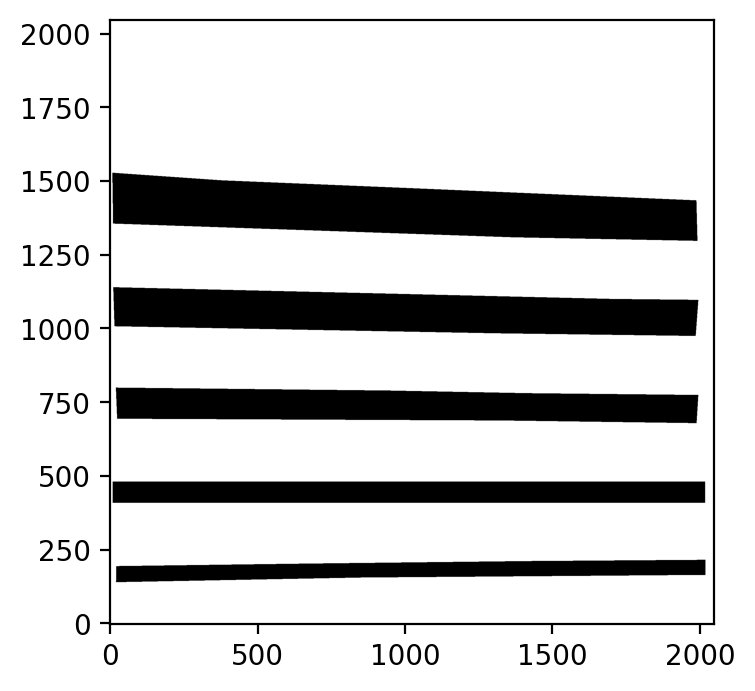

In [6]:
order=read_ds9("order19.reg")
ndim=fits.getdata(darkic.files[0]).shape #.data.shape
ordermask=order[0].to_mask().to_image(ndim)
rinter=read_ds9("spec/cal/interorder.reg")#.to_mask().to_image(ndim)
interorder=np.zeros(ndim)
for r in rinter:
    #r.to_mask().to_image(ndim)
    interorder+=r.to_mask().to_image(ndim)
interorder[np.where(interorder>0)]/=interorder[np.where(interorder>0)]
#offorder=~ordermask.astype(np.bool)
plt.imshow(interorder,cmap='binary',origin='lower')
plt.show()

### Make master flat, trace orders, fit and subtract scattered light using inter-order regions
#### Start by making the combined dark frame for the flat

#### Note: flattening usually occurs before rectification of spectra, but for NIRSPAO I have found that doing rectification prior to flattening can result in cleaner spectra. Try it both ways.

In [ ]:
# get exp time of flats and make list of dark files
exptime=fits.getheader(flatic.files[-1])['elaptime']
darks=darkic.files_filtered(**{'elaptime':exptime})[1:7]
flats=flatic.files[-8:]

#print(darks,flats)

# run reduce_flat to reduce darks and make dark-subtracted, combined flat
reduce_flat(flats,darks,outflat="spec/cal/Flat.fits",outdark="spec/cal/Dark.fits",\
                      clean=True,dark_subtract=True,flat_normalize=True,ordermask=ordermask)
#hrot=h.copy()
# frot=np.rot90(flat,-1)
# drot=np.rot90(dark,-1)
# fits.writeto("spec/cal/Flatn_rot.fits",data=frot,overwrite=True)
# fits.writeto("spec/cal/Dark_rot.fits",data=drot,overwrite=True)


In [ ]:
zlim=ZScaleInterval().get_limits(flat)
plt.imshow(flat,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])

In [ ]:
flat=fits.getdata("spec/cal/Flat.fits")
dark=fits.getdata("spec/cal/Dark.fits")
#interorder=read_ds9("spec/cal/interorder.reg")[0].to_mask().to_image(flat.shape)
#flatinter=flat*interorders.astype(int)
datasub,scattermod=sub_scatter(flat,mask=1.0-interorder.astype(int))
fits.writeto("spec/cal/Flat.sctsub.fits",data=datasub,header=fits.getheader("spec/cal/Flat.fits"),overwrite=True)
flatnorm,flatscale=normalize(datasub,ordermask)
fits.writeto("spec/cal/NFlat.sctsub.fits",data=flatnorm,header=fits.getheader("spec/cal/NFlat.fits"),overwrite=True)
#zlim=ZScaleInterval().get_limits()
fig=plt.figure()
ax1=fig.add_subplot(131)
zlim=ZScaleInterval().get_limits(flat*interorder.astype(int))
ax1.imshow(flat*interorder.astype(int),origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
ax2=fig.add_subplot(132)
zlim=ZScaleInterval().get_limits(scattermod*interorder)
ax2.imshow(scattermod*interorder,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
ax3=fig.add_subplot(133)
zlim=ZScaleInterval().get_limits(datasub)
ax3.imshow(datasub,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
plt.show()
#plt.imshow(scattermod,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
#nflatsub,nmask,nscale=normalize(flat,ordermask)
#fits.writeto("spec/cal/nFlat.fits",data=nflatsub,overwrite=True)
# flatrect,wavearr=rectify(flat,"spec/spat.map","spec/spec.map")
# #flatmask=np.zeros(flatrect.shape)
# #flatrect/=np.median(flatrect[5:-5,10:1990])
# mean=np.median(flatrect[6:270,10:2001])
# print("norm factor: ",mean)
# flatnorm=flatrect/mean
# flatnorm[np.where(flatnorm>5.0)]=1
# flatnorm[np.where(flatnorm < 0.2)]=1
# #flatnorm/=np.median(flatnorm[np.where(flatnorm!=1.0)])
# #flatnorm[np.where(flatnorm==0.0)]=1

In [ ]:

flat=fits.getdata("spec/cal/NFlat.fits")
flatrect,wavegrid=rectify(flat,'spec/spat.map','spec/spec.map',mask=(flat==1.0))
#flatrect==fits.getdata("spec/cal/NFlat.rect.fits")
#flat=fits.getdata("spec/cal/nFlat_rect.fits")

hred=reduce_obj(arcic.files[-1],darkic.files[-1],"spec/cal/NFlat.fits",clean=True,\
                   flatten=True,rectify_image=True,spatmap='spec/spat.map',specmap='spec/spec.map',\
                   bkg_subtract=False)
hred.writeto("spec/cal/Arc.1.fits",overwrite=True)


hrect=reduce_obj(arcic.files[-1],darkic.files[-1],"spec/cal/NFlat.fits",clean=True,\
                   flatten=False,rectify_image=True,spatmap='spec/spat.map',specmap='spec/spec.map',\
                   bkg_subtract=False)
hred2=fits.PrimaryHDU(data=hrect.data/flatrect,header=hrect.header)
hred2.writeto("spec/cal/Arc.2.fits",overwrite=True)

fig=plt.figure()
ax1=fig.add_subplot(211)
zlim=ZScaleInterval().get_limits(hred.data)
ax1.imshow(hred.data,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
ax2=fig.add_subplot(212)
zlim=ZScaleInterval().get_limits(hred2.data)
ax2.imshow(hred2.data,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
# ax3=fig.add_subplot(413)
# zlim=ZScaleInterval().get_limits(bg2)
# ax3.imshow(bg2,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
# ax4=fig.add_subplot(414)
# zlim=ZScaleInterval().get_limits(datred2)
# ax4.imshow(datred2,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
# plt.show()

# plt.figure()
# plt.plot(np.mean(datred[130:140,6:2010],axis=0),'r-')
# #plt.plot(np.sum(harcred.data[130:140,:],axis=0),'r--')
# plt.plot(np.mean(datred2[130:140,6:2010],axis=0),'b-')
# plt.ylim(-5.0,10.0)
#plt.plot(np.sum(datflat[130:140,:],axis=0),'b--')
# zlim=ZScaleInterval().get_limits(harcred.data)
plt.show()

In [ ]:
# Reduce cal star
# read hdus, select ABBA pattern,
print(std1ic.summary['file'],std1ic.summary['elaptime'])
print(std2ic.summary['file'],std2ic.summary['elaptime'])

flat=fits.getdata("spec/cal/NFlat.fits")
#flatr=fits.getdata('spec/cal/NFlat.rect.fits')
#hdark=fits.open(darkic.summary['file'][-1])[0]

# Reduce star 1
hdus=[h for h in std1ic.hdus()][1:] # first exposure is bad
print(hdus[0].header['ofname'])
#hdark.data*=(hdus[0].header['elaptime']/hdark.header['elaptime'])
hduAB=reduce_obj(std1ic.files[2],std1ic.files[1],"spec/cal/NFlat.fits",clean=True,flatten=True,\
                  rectify_image=True,bkg_subtract=False,\
                  spatmap='spec/spat.map',specmap='spec/spec.map')

#hduA=reduce_obj(hdus[0],hdark,flat,clean=False,flatten=False,rotate_image=True,rectify_image=False,bkg_subtract=False,statbox=statbox)
#hduB=reduce_obj(hdus[1],hdark,flat,clean=False,flatten=False,rotate_image=True,rectify_image=False,bkg_subtract=False,statbox=statbox)
#hduAB2=reduce_obj(hdus[2],hdus[3],flat,clean=False,flatten=True,rotate_image=True,rectify_image=False,bkg_subtract=False,statbox=statbox)
#hduAB=reduce_obj(hdus[0],hdus[1],flat,clean=False,flatten=True,rectify_image=True)
#fits.writeto("spec/cal/hd225200_ff_rot.A.fits",data=hduA.data,header=hduA.header,overwrite=True)
#fits.writeto("spec/cal/hd225200_ff_rot.An.fits",data=-1.0*hduA.data,header=hduA.header,overwrite=True)
#fits.writeto("spec/cal/hd225200_ff_rot.B.fits",data=hduB.data,header=hduB.header,overwrite=True)
#fits.writeto("spec/cal/hd225200_ff_rot.Bn.fits",data=-1.0*hduB.data,header=hduB.header,overwrite=True)
fits.writeto("spec/hd225200_A-B.fits",data=hduAB.data,header=hduAB.header,overwrite=True)
#fits.writeto("spec/cal/hd225200_ff_rot.2.fits",data=hduAB2.data,header=hduAB1.header)
#datAB=np.mean([hduAB1.data,hduAB2.data],axis=0)
#fits.writeto("spec/cal/hd225200_ff_rot.fits",data=datAB,header=hduAB1.header,overwrite=True)
#fits.writeto("spec/cal/hd225200_ff_rot_neg.fits",data=-1.0*datAB,header=hduAB1.header,overwrite=True)

## Form combined sky spectrum, and reduce object spectra

In [ ]:
from astropy.convolution import interpolate_replace_nans
help(interpolate_replace_nans)

kern=Box2DKernel(5)
hsky=[h for h in skyic.hdus()]
skydat=[]
skymask=[]
mjdsky=[]
for h in hsky:
    print("Image: ",h.header['ofname'])
    dat=h.data.copy()
    print("Exposure time: ",h.header['elaptime'])
    #print("Cleaning CRs...")
    #print(h.header['date-obs']+'T'+h.header['utstart'])
    mjdsky.append(Time(h.header['date-obs']+'T'+h.header['utstart'],format='isot').mjd)
   # print(tobs.mjd)
  #  datcl,crmask=cosmic_clean(dat,sigclip=5.0,sigfrac=0.4,objlim=5.0)
    
  #  datcl[np.where(crmask==True)]=np.nan
    
  #  datred=interpolate_replace_nans(datcl,kern)
   # crmask=(dat<=0.) | (dat >= 25000.)
    # divide by exposure time and append
    #dat/=h.header['elaptime']
    skydat.append( dat)

mjdsky=np.array(mjdsky)  
skycomb=np.mean(skydat,0)#.mean(axis=0)
#skypix=np.sum(1-skymask).astype(float)
#skycomb/=2.0
#skycomb=np.mean(skydat,axis=0)

fits.writeto("spec/Sky_avg.fits",data=skycomb,header=h.header,overwrite=True)
# fits.writeto("spec/Sky_rot.fits",data=np.rot90(skycomb.data,-1),header=h.header,overwrite=True)

Filtering rows with single filter
False


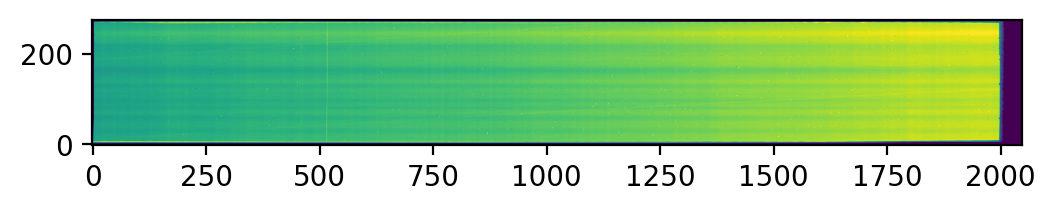

Filtering each row independently
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
F

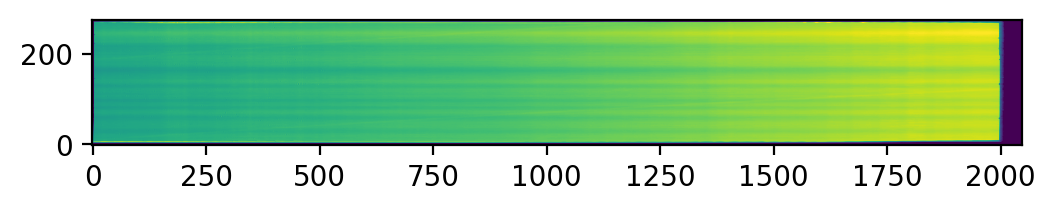

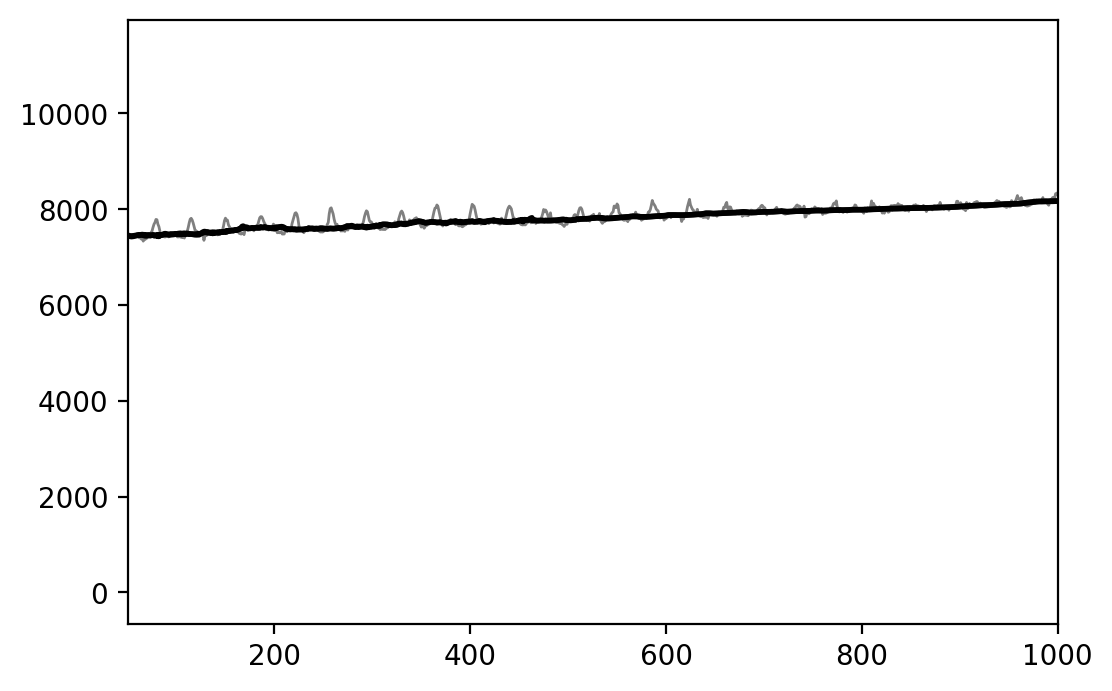

In [10]:
#sky=fits.getdata('spec/Sky_avg.fits')
thresh=3.0
dat=fits.getdata('spec/Sky_avg.fits')
flat=fits.getdata('spec/cal/Nflat.fits')
#datfits.getdata("spec/cal/NFlat.fits")
#sky/=flat
spec,wave=rectify(dat/flat,'spec/spat.map','spec/spec.map')
#dat=polybkg(dat)
#dat/=flat
plt.figure()
ax1=plt.subplot(211)
zlim=ZScaleInterval().get_limits(datcorr)
ax1.imshow(datcorr,origin='lower',vmin=zlim[0],vmax=zlim[1])
datcorr=fringe2D(spec,medwidth=41,thresh_peak=thresh,correct_each_row=False)
plt.show()

datcorr2=fringe2D(spec,medwidth=41,thresh_peak=thresh,correct_each_row=True)
plt.figure()
ax2=plt.subplot(212)
zlim=ZScaleInterval().get_limits(datcorr2)
ax2.imshow(datcorr2,origin='lower',vmin=zlim[0],vmax=zlim[1])
plt.show()


plt.figure()
plt.plot(spec[30:-30,:].mean(0),'k-',alpha=0.5,linewidth=1)
plt.plot(datcorr[30:-30,:].mean(0),'k-',linewidth=2)
plt.plot(datcorr2[30:-30,:].mean(0),'k-',linewidth=2)
plt.xlim(50,1000)
plt.show()

In [49]:
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import noise_region_uncertainty,snr_threshold
from astropy.convolution import convolve,Box2DKernel
#from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
from astropy.constants import c
# ~~ reduce and combine flat

#hobj=[h for h in objic.hdus()]
mjdsky=np.array([Time(h.header['date-obs']+'T'+h.header['utstart'],format='isot',scale='utc').mjd for h in skyic.hdus()])

flat='spec/cal/NFlat.fits'
#sky='spec/Sky_avg.fits'


for obj in objic.files:
   # print("Reducing image: ",h.header['ofname'])
   # hcopy=h.copy()
    #print(h.header['airmass'])
    h=fits.getheader(obj)
    mjdobj=Time(h['date-obs']+'T'+h['utstart'],format='isot',scale='utc').mjd
    isky=np.argmin(np.abs(mjdobj-mjdsky))
    sky=skyic.files[isky]
    print("Sky frame closest in time: ",sky)
    # divide by exposure time
   # hcopy.data/=float(hcopy.header['elaptime'])
    
    # reduce+rectify
    hred=reduce_obj(obj,sky,flat,clean=True,flatten=True,outname='spec/s%04d'%h['frameno'],\
                    rectify_image=True,bkg_subtract=True,bkg_boxsize=(1,6),fringe_corr=True,filt_width=61,\
                    fringe_thresh=2.0,specmap='spec/spec.map',spatmap='spec/spat.map')
  

#     fits.writeto('spec/'+hred.header['ofname'][:-5]+".fringe.fits",data=datcorr,\
#                  header=hred.header,overwrite=True)
#     swcs=WCS(hred).sub(0)
#     xpix=np.arange(hred.data.shape[1])
#     wvlgrid,junk=swcs.wcs_pix2world(xpix,np.ones(xpix.size),0)
#     #print(wvlgrid)
#     #wavearr=hred.header['crval1']+hred.header['cdelt1']*
#     #noise_region = SpectralRegion([(10*u.pix,100*u.pix), (900*u.pix, 1600*u.pix)])
#     specred = Spectrum1D(flux=hred.data*u.adu/u.s,spectral_axis=(u.m*wvlgrid).to(u.um),\
#                          rest_value=4.05226*u.um,velocity_convention="optical")
#     specfringe=  Spectrum1D(flux=datcorr*u.adu/u.s,spectral_axis=(u.m*wvlgrid).to(u.um),\
#                          rest_value=4.05226*u.um,velocity_convention="optical")
#     #specunc = noise_region_uncertainty(specred, noise_region)
#     #specred.uncertainty=specunc.uncertainty
#     #print(specred.uncertainty)
    
#     # define observed wavelength, convert to heliocentric frame
#     waveobs=specred.wavelength
#     velobs=specred.velocity
#     #print(waveobs,velobs)
#     vcorr=heliocorr('NGC253',tobs,observatory='Keck')
#     print("Heliocentric velocity correction: ",vcorr)
    
#     wvlhelio = waveobs.to(u.um) * (1. * u.dimensionless_unscaled + vcorr/c.to(u.km/u.s)) 
#     vhelio = velobs.to(u.km/u.s) + vcorr
    
#     #kernel=Box2DKernel(6)
#    # kernel=Gaussian2DKernel(x_stddev=1.0,y_stddev=3.0)
#     #specsmooth = signal.medfilt(specred.flux,[5,7])
#     #specsmooth = convolve(specred, kernel, boundary='fill', fill_value=0., nan_treatment='interpolate')
    
    
#     #specmasked = snr_threshold(specred, 1.5) 
#     #fluxmasked=np.ma.masked_array(specmasked.flux,mask=specmasked.mask,fill_value=np.nan)
#     fig=plt.figure()
#     #zlim=ZScaleInterval().get_limits(fluxmasked)
# #     spatpeak=np.argmax(np.median(datfringe[:,620:740],1))
# #     #spatpeak=133
# #    # print("Peak of spat prof: ",spatpeak)
# #     yex_lo=spatpeak-100
# #     yex_hi=spatpeak+100
#     ax1=fig.add_subplot(211)
#     zlim=ZScaleInterval().get_limits(specred.flux)
#     ax1.imshow(specred.flux,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])

   
#     ax2=fig.add_subplot(212)
#     zlim=ZScaleInterval().get_limits(specfringe.flux)
#     ax2.imshow(specfringe.flux,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])
#     plt.show()
  
    #fits.writeto('spec/'+h.header['ofname'][:-5]+".ff.fits",data=hred.data/flatrect,header=hred.header,overwrite=True)

    

Sky frame closest in time:  /Users/dcohen/RESEARCH/NGC253_NIRSPAO/KOA_26773/NIRSPEC/2019aug14/raw/spec/rotated/nspec190814_0057.fits
Cleaning cosmic rays...
Normalizing by elaptime
Subtracting image pair and dividing by flat...
Rectifying in spatial and spectral dimensions...
Updating fits header...



Subtracting residual median background...
Filtering rows with single filter
Sky frame closest in time:  /Users/dcohen/RESEARCH/NGC253_NIRSPAO/KOA_26773/NIRSPEC/2019aug14/raw/spec/rotated/nspec190814_0057.fits
Cleaning cosmic rays...
Normalizing by elaptime
Subtracting image pair and dividing by flat...
Rectifying in spatial and spectral dimensions...
Updating fits header...



Subtracting residual median background...
Filtering rows with single filter
Sky frame closest in time:  /Users/dcohen/RESEARCH/NGC253_NIRSPAO/KOA_26773/NIRSPEC/2019aug14/raw/spec/rotated/nspec190814_0057.fits
Cleaning cosmic rays...
Normalizing by elaptime
Subtracting image pair and dividing by flat...
Rectifying i

## Convert wavelengths/velocities to heliocentric frame

In [ ]:
#image=fits.getdata("spec/"+"nspec190814_0055.red.fits")
image=fits.getdata("spec/"+"Flatn.rect.fits")
zlim=ZScaleInterval().get_limits(image)
plt.imshow(image,origin='lower',cmap='jet',vmin=zlim[0],vmax=zlim[1])

In [ ]:
hduflatraw=fits.open(reddir+caldir+"spec/Flatsub.raw.fits")[0]
flatrect,wavearr=rectify(hduflatraw.data,'spat.map','spec.map',mask=hduflatraw.data==1,rotate=True)
normmask=read_ds9("statbox.reg")[0].to_mask().to_image(hdurect.data.shape)
flatnorm,normconst=normalize(hdurect.data,normmask)
print("Normalization constant",normconst)
fits.writeto(reddir+caldir+"spec/Flatnorm.fits",data=flatnorm,header=hdurect.header,overwrite=True)
# flatscaled=ccdp.combine(ccdlist,method='median',scale=1./np.array(medorder),
#                      # sigma_clip=True,sigma_clip_func=np.ma.median, sigma_clip_dev_func=np.ma.std, sigma=4.0,\
#                      minmax_clip=True, minmax_clip_min=0., minmax_clip_max=25000.) 

# flatsnorm,cnorm=normalize(flatscaled.data,normmask)   
# fits.writeto(reddir+caldir+"spec/Flatmed.scaled.fits",data=flatsnorm,header=flatscaled.header,overwrite=True) 

### Reduce standard star, check flat-fielding and properties of spectrum. Flatten before or after rectification?

In [ ]:
# read hdus, select ABBA pattern,
print(std1ic.summary['file'],std1ic.summary['elaptime'])
print(std2ic.summary['file'],std2ic.summary['elaptime'])

flat=fits.getdata(reddir+caldir+"spec/Flatnorm.raw.fits")

# Reduce star 1

hdus=[h for h in std1ic.hdus()][1:] # first exposure is bad
nodAB1=(hdus[0],hdus[1])
nodAB2=(hdus[3],hdus[2])

hduAB1=reduce_objframe(nodAB1,flat)
hduAB2=reduce_objframe(nodAB2,flat)
hduAB1.writeto("hd225200.1.fits")
hduAB2.writeto("hd225200.2.fits")
datAB=np.mean([hduAB1.data,hduAB2.data],axis=0)
fits.writeto("hd225200.fits",data=datAB,header=hduAB1.header,overwrite=True)

# Repeat, for star 2
hdus=[h for h in std2ic.hdus()][1:] # first exposure is bad
nodAB1=(hdus[0],hdus[1])
nodAB2=(hdus[3],hdus[2])

hduAB1=reduce_objframe(nodAB1,flat)
hduAB2=reduce_objframe(nodAB2,flat)
hduAB1.writeto("hd3604.1.fits")
hduAB2.writeto("hd3604.2.fits")
datAB=np.mean([hduAB1.data,hduAB2.data],axis=0)
fits.writeto("hd3604.fits",data=datAB,header=hduAB1.header,overwrite=True)





In [ ]:
std1=fits.getdata("hd225200.fits")
std2=fits.getdata("hd3604.fits")

zs=ZScaleInterval()
zlim=zs.get_limits(std1.data)
plt.imshow(std1,origin='lower',cmap='viridis',vmin=zlim[0],vmax=zlim[1])
plt.show()

zs=ZScaleInterval()
zlim=zs.get_limits(std2.data)
plt.imshow(std2,origin='lower',cmap='viridis',vmin=zlim[0],vmax=zlim[1])
plt.show()


### Reduce object frames. First create master sky, then reduce each object frame individually.

In [ ]:
hsky=skyic.hdus()
ccdlist=[]
flat = fits.getdata(reddir+caldir+"spec/Flatnorm.raw.fits")
#dark = fits.getdata(reddir+caldir+"spec/Darkmed.scaled.fits")
for hdu in hsky:
    
    fname=hdu.header['ofname']
    print(fname,hdu.header['object'])
    
    hduraw=hdu.copy()
    #print(type(hduraw))
    hdured=reduce_objframe(hduraw,flatdata=flat,cr_clean=True,flatten=False,rectify_image=False)
    fits.writeto(reddir+objdir+'spec/'+fname[:-5]+".raw.fits",data=hdured.data,header=hdured.header,overwrite=True)

    ccd=CCDData(hdured.data,header=hdured.header,unit='adu')
    
    ccdlist.append(ccd)

# combine sky
skycomb=ccdp.combine(ccdlist,method='average',\
                     minmax_clip=True, minmax_clip_min=0., minmax_clip_max=25000.)
fits.writeto(reddir+objdir+"spec/Sky.raw.fits",data=skycomb.data,header=skycomb.header,overwrite=True)



In [ ]:
hobj=objic.hdus()
#flatraw = fits.getdata(reddir+caldir+"spec/Flatnorm.raw.fits")
flatraw = fits.getdata(reddir+caldir+"spec/Flatnorm.raw.fits")
flat = fits.getdata(reddir+caldir+"spec/Flatsub.fits")
hdusky = fits.open(reddir+objdir+"spec/nspec190814_0057.raw.fits")[0]

ccdlist=[]
#dark = fits.getdata(reddir+caldir+"spec/Darkmed.scaled.fits")
fig,ax=plt.subplots(10,2)
iplot=0
for hdu in hobj:
    
    fname=hdu.header['ofname']
    print(fname,hdu.header['object'],hdu.header['elaptime'])
    
    hduraw=hdu.copy()
    tobj=hduraw.header['elaptime']
    tsky=hdusky.header['elaptime']

    sky=hdusky.data * (tobj/tsky)
    
    reduced=hduraw.data-sky
    
    #reduced=datasub/flatraw
    
    dataout,wavearr=rectify(reduced,"spat.map","spec.map",rotate=True)
    
    dataout/=flat
    
    zs=ZScaleInterval()
    zlim=zs.get_limits(dataout)
    axi=ax.reshape(ax.size)[iplot]
    axi.imshow(dataout,origin='lower',cmap='cubehelix',vmin=zlim[0],vmax=zlim[1])
    axi.set_xticklabels([])
    axi.set_yticklabels([])
    iplot+=1
    #hduin=
    #hdured=reduce_objframe((hduraw,hdusky),flatdata=flatraw,cr_clean=True,flatten=True,rectify_image=True)
    #fits.writeto(reddir+objdir+'spec/'+fname[:-5]+".red.fits",data=hdured.data,header=hdured.header,overwrite=True)
plt.subplots_adjust(hspace=0.01,wspace=0.01)
plt.show()

#     ccd=CCDData(hdured.data,header=hdured.header,unit='adu')
    
#     ccdlist.append(ccd)

# # combine sky
# objcomb=ccdp.combine(ccdlist,method='sum',\
#                      minmax_clip=True, minmax_clip_min=0., minmax_clip_max=25000.)
# fits.writeto(reddir+objdir+"spec/n253_sum.fits",data=objcomb.data,header=objcomb.header,overwrite=True)

In [ ]:
darkric=ccdp.ImageFileCollection(reddir+caldir+'/spec/darks/')
flatric=ccdp.ImageFileCollection(reddir+caldir+'/spec/flats/')
darks = reduced_images.summary['imagetyp'] == 'DARK'
dark_times = set(darkric.summary['exptime'][])
#print(dark_times)

In [ ]:
from pyraf import iraf
from iraf import noao

noao.imred.ccdred.run()
noao.imred.ccdred.ccdproc.unlearn()
#iraf.ccdred.ccdproc.dParam(cl=0)
#noao.imred.ccdred.ccdproc.dParam(cl=0)
noao.imred.ccdred.ccdproc.biassec=overscanreg
noao.imred.ccdred.ccdproc.trimsec=trimsec
#noao.imred.ccdred.ccdproc.ccdsec=trimsec
noao.imred.ccdred.ccdproc.overscan='yes'
noao.imred.ccdred.ccdproc.trim='yes'
noao.imred.ccdred.ccdproc.zero=''#biasfiles[0]
noao.imred.ccdred.ccdproc.zerocor='no'
noao.imred.ccdred.ccdproc.darkcor='no'
noao.imred.ccdred.ccdproc.flatcor='no'
noao.imred.ccdred.ccdproc.illumcor='no'
noao.imred.ccdred.ccdproc.fringecor='no'
noao.imred.ccdred.ccdproc.fixpix='yes'
noao.imred.ccdred.ccdproc.dark=''#reddir+caldir+'spec/'+'Dark.1.fits'
noao.imred.ccdred.ccdproc.flat=''#reddir+caldir+'spec/'+'Flat.1.fits'
noao.imred.ccdred.ccdproc.interactive='yes'

#noao.imred.ccdred.ccdproc.eParam()

__Edit image headers to include EXPTIME as the total elapsed integration time__

### Run `ccdred.darkcombine` & `ccdred.flatcombine` to create combined dark/flat exposures

In [ ]:
iraf.imhead('Flat.1.fits',long='yes')
#ccd.ccdmask(reddir+caldir+'spec/Dark.1.fits')

In [ ]:
imred=iraf.noao.imred
print(fflist[3:])

#### Subtract dark from flat

In [ ]:
hf=fits.open('./cal/spec/Flat.2.fits')
hd=fits.open('./cal/spec/Dark.1.fits')

datfsub=(hf[0].data/float(hf[0].header['exptime']))-(hd[0].data/float(hd[0].header['exptime']))

fits.writeto("./cal/spec/Flat.2.sub.fits",data=datfsub,header=hf[0].header,overwrite=True)

#Flat.3.fits','-','/cal/spec/Dark.1.fits','cal/spec/Flat.3.sub.fits')

Combine flat frames to make median flat image, & subtract the median dark from that image. __Make sure flats & darks have same exp time!__

In [ ]:
flathdr = fits.open(flatframes[-1])[0].header
if flathdr['ELAPTIME'] != darkhdr['ELAPTIME']:
    print("ERROR: flats & darks have different exposure times!!!")
flatims = [fits.open( ff )[0].data for ff in flatframes]   
flatcomb = np.nanmedian( np.array(flatims), axis=0)
fits.writeto(outdir+"cal/"+"flat_10s_med.fits",data=flatcomb,header=flathdr,overwrite=True)
# OPTIONAL, SUBTRACT DARK FROM FLAT
#flatmaster = flatcomb - darkcomb
#flatmaster[np.where(flatmaster <=0.)]=1.


In [ ]:
# Only using one arc image with one dark for now
flatcomb = fits.open(outdir+"cal/"+"flat_10s_med.fits")[0].data
darkcomb = fits.open(outdir+"cal/"+"dark_10s_med.fits")[0].data
%matplotlib inline
#%matplotlib notebook

flatsub = flatcomb - darkcomb
fits.writeto(outdir+"cal/"+"flat_10s_sub.fits",data=flatsub,header=flathdr,overwrite=True)
#fig=plt.figure(figsize=(6,6))
#%matplotlib notebook
plt.plot(np.arange(flatcomb.shape[0]),np.nanmedian(flatsub,axis=1))
plt.show()

In [ ]:
norm_flat = 14000.0 # approximate median of flat in spectral order for normalization

In [ ]:
flatsub = fits.open(outdir+"cal/"+"flat_10s_sub.fits")[0].data
archdr = fits.open(arcframes[-1])[0].header
adarkhdr = fits.open(adarkframes[-1])[0].header
arc=np.nanmedian([fits.open(af)[0].data for af in arcframes],axis=0)
adark=np.nanmedian([fits.open(adf)[0].data for adf in adarkframes],axis=0)
arcsub = arc - adark
fits.writeto(outdir+"cal/"+"arc_150s_sub.fits",data=arcsub,header=archdr,overwrite=True)


arcflat = arcsub.copy()

arcflat[np.where(flatsub>0.)] /= (flatsub[np.where(flatsub>0.)]/norm_flat)
fits.writeto(outdir+"cal/"+"arc_150s_flattened.fits",data=arcflat,header=archdr,overwrite=True)

#fits.writeto(outdir+"cal/"+"arc_10s_flattened.fits",data=arcflat,header=archdr,overwrite=True)

__Calibration star__

Clean cosmic rays using ``astroscrappy.detect_cosmics``

In [ ]:
stdstar = [fits.getdata(sf) for sf in stdframes]
#print([fits.getheader(sf)['ELAPTIME'] for sf in stdframes])

# clean cosmic rays from raw frames
stdcr=[]
for i in stdstar:
    crmask,cleanim = detect_cosmics(i, sigclip=4.0, \
            objlim=20, gain=2.85, readnoise=10., niter=4,\
                                cleantype='medmask', verbose=True)
    stdcr.append(np.ma.masked_array(cleanim,mask=crmask))
stdstar=[s.data for s in stdcr]
#print(stdcr[0].data.shape)  


In [ ]:
fig=plt.figure(figsize=(15,10))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
imshow_norm(stdstar[0].data,ax1,origin='lower',\
                    interval=ZScaleInterval(),stretch=SqrtStretch())
imshow_norm(stdcr[0].data,ax2,origin='lower',\
                    interval=ZScaleInterval(),stretch=SqrtStretch())
plt.show()

In [ ]:
stdA = np.nanmean([stdstar[0],stdstar[3]],axis=0)
stdB = np.nanmean([stdstar[1],stdstar[2]],axis=0)
stdBneg = stdB*-1.0
# stdAB1 = stdstar[0]-stdstar[1]
# #stdAB1[np.where(flatsub>0.)]/=(flatsub[np.where(flatsub>0.)]/norm_flat) 
# stdAB2 = stdstar[3]-stdstar[2]

fig,axs=plt.subplots(1,2,figsize=(15,10))
axs[0].imshow(stdA-stdB,origin='lower',vmin=-150,vmax=150)
axs[1].imshow(stdA+stdBneg,origin='lower',vmin=-150,vmax=150)
plt.show()
#stdAB2[np.where(flatsub>0.)]/=(flatsub[np.where(flatsub>0.)]/norm_flat) 
stdAB = stdA-stdB #np.nanmean([stdAB1,stdAB2],axis=0)
stdAB[np.where(flatsub>0.)]/=(flatsub[np.where(flatsub>0.)]/norm_flat) 
stdA[np.where(flatsub>0.)]/=(flatsub[np.where(flatsub>0.)]/norm_flat)
stdB[np.where(flatsub>0.)]/=(flatsub[np.where(flatsub>0.)]/norm_flat)
stdhdr = fits.getheader(stdframes[-1])

# flat-field?
fits.writeto(outdir+"cal/"+"std_A_flattened.fits",data=stdA,header=stdhdr,overwrite=True)
fits.writeto(outdir+"cal/"+"std_B_flattened.fits",data=stdB,header=stdhdr,overwrite=True)
#fits.writeto(outdir+"cal/"+"std_Bneg.fits",data=stdBneg,header=stdhdr,overwrite=True)
#fits.writeto(outdir+"cal/"+"std_AB.fits",data=stdAB,header=stdhdr,overwrite=True)
#fits.writeto(outdir+"cal/"+"std_A-2B.fits",data=stdAB+stdBneg,header=stdhdr,overwrite=True)

# Science frame reduction (either rectified or raw)

__First read sky spectra, clean of cosmic rays__ 

In [ ]:
sky=[fits.getdata(skf) for skf in skyframes]
skyhdr=[fits.getheader(skf) for skf in skyframes]

In [ ]:
skycr=[]
for i in sky:
    crmask,cleanim = detect_cosmics(i, sigclip=4.0, \
            objlim=20, gain=2.85, readnoise=10., niter=4,\
                                cleantype='meanmask', verbose=True)
    skycr.append(np.ma.masked_array(cleanim,mask=crmask))
sky=[s for s in skycr]


In [ ]:
# fig=plt.figure(figsize=(8,8))
# ax1=fig.add_subplot(111)
# #ax2=fig.add_subplot(122)
# imshow_norm(sky[0],ax1,origin='lower',\
#                     interval=ZScaleInterval(),stretch=SqrtStretch())
# # imshow_norm(stdcr[0].data,ax2,origin='lower',\
# #                     interval=ZScaleInterval(),stretch=SqrtStretch())
# plt.show()

__Create mean sky image__

In [ ]:
skyavg=np.nanmean(sky,axis=0)
fits.writeto(outdir+"sky_mean.fits",data=skyavg,header=skyhdr[-1],overwrite=True)

__Read object frames, clean of cosmic rays, subtract sky__

In [ ]:

for of in objframes:
    sci=fits.getdata(of)
    scihdr=fits.getheader(of)
    frameno=scihdr['framenum']
   # print('%04d'%frameno)
   # break
    
    # clean CRs
    crmask,cleanim = detect_cosmics(sci, sigclip=5.0, \
            objlim=30, gain=2.85, readnoise=10., niter=4,\
                    cleantype='meanmask', verbose=True)
    
    # subtract sky
    scisub = cleanim - sky[0].data
    
    #scisub -= np.ma.median(scisub)
    
    # flat-field
    scisub[np.where(flatsub>0.)] /= (flatsub[np.where(flatsub>0.)]/norm_flat)
    
    fits.writeto(outdir+'ns_%04d.fits'%frameno,data=scisub,header=scihdr,overwrite=True)
    

### Display flat, clip out order for statistics, & normalize. Use ginga Jupyter widget for display.

# create a Jupyter image that will be our display surface
# format can be 'jpeg' or 'png'; specify width & height to set viewer size
# PNG will be a little clearer, especially with overlaid graphics, but
# JPEG is faster to update
from IPython import display
import ipywidgets as widgets
jup_img = widgets.Image(format='jpeg', width=500, height=500)
#
# from ginga.web.pgw import ipg
# use_opencv = True
# server = ipg.make_server(host='localhost',numthreads=5,port=9914, use_opencv=use_opencv)
# #server.thread_pool.stopall()
# server.start(no_ioloop=True)
# v1 = server.get_viewer('v1')
# v1.set_html5_canvas_format('jpeg')

In [ ]:
%matplotlib inline
# Boilerplate to create a Ginga viewer connected to this widget
# this could be simplified, or hidden behind a class or convenience 
# method
# NOTE: you don't have to specify a log file--& if you are not interested
# in the log just specify null=True for a null logger
# level=10 will give you the most debugging information
from ginga.misc.log import get_logger
logger = get_logger("my viewer", log_stderr=False, log_file='/tmp/ginga.log', level=40)

from ginga.web.jupyterw.ImageViewJpw import EnhancedCanvasView
v1 = EnhancedCanvasView(logger=logger)
# set our linkage between the jupyter widget at ginga
v1.set_widget(jup_img)

# enable all possible keyboard & pointer operations
bd = v1.get_bindings()
bd.enable_all(True)

# coordinates = widgets.HTML('<h3>coordinates show up here</h3>')
# # callback to display position in RA/DEC deg
# def mouse_move(viewer, button, data_x, data_y, w):
#     image = viewer.get_image()
#     if image is not None:
#         ra, dec = image.pixtoradec(data_x, data_y)
#         w.value = "x=%f, y=%f"% (ra, dec)

# v1.add_callback('cursor-changed', mouse_move, coordinates)

In [ ]:
%%javascript
 /* some magic to keep the cell contents from scrolling
    (when we embed the viewer)
  */
IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
 }

In [ ]:
# embed the viewer here

widgets.VBox([jup_img])#,coordinates])#, coordinates])

In [ ]:
v1.load("flat_master.fits")
# also load as fits hdu

In [ ]:
# swap XY, flip Y, change colormap back to "ramp"
v1.set_color_map('ramp')
# Set color distribution algorithm
# choices: linear, log, power, sqrt, squared, asinh, sinh, histeq, 
v1.set_color_algorithm('sqrt')
#v1.transform(False, True, True)
v1.rotate(90.)

v1.auto_levels()
v1.show()

In [ ]:
# add a canvas to the image & set the draw type
canvas = v1.add_canvas()
canvas.set_drawtype('box', color='magenta', fill=True, fillcolor='magenta', fillalpha=0.2)

In [ ]:
#v1.show()

In [ ]:
# put the canvas in edit mode
canvas.enable_edit(True)
canvas.set_draw_mode('edit')

In [ ]:
v1.show()

In [ ]:
rectorder=canvas.objects[0]

In [ ]:
img=v1.get_image()
#print(img)
orderimg = img.cutout_shape(rectorder)
normorder = np.ma.median(orderimg)
print(np.median(normorder.data))
#np.ma.median(orderimg)
#print(np.median(orderimg.data),np.ma.median(orderimg))

__Normalize flat by median & updated hdu__

In [ ]:
#print(normorder)
hdumast = fits.open("flat_master.fits",mode='update')
ixnz=np.where(hdumast[0].data>0.)
hdumast[0].data[ixnz]/=normorder
#ixnz=np.where(hdumast[0].data>0.)
hdumast.flush()
#print(normorder)
#flatmaster=flatmaster/normorder


## Step 2) Create "master arc": dark-subtracted, flat-fielded if necessary

In [ ]:
# #%matplotlib notebook
# v1.center_image()
# v1.load_data(flatmaster)
# # swap XY, flip Y, change colormap back to "ramp"
# v1.set_color_map('ramp')
# # Set color distribution algorithm
# # choices: linear, log, power, sqrt, squared, asinh, sinh, histeq, 
# v1.set_color_algorithm('sqrt')
# #v1.transform(False, True, True)
# v1.rotate(90.)

# v1.auto_levels()
# v1.show()

In [ ]:
v1.load("arc_master.fits")

# swap XY, flip Y, change colormap back to "ramp"
v1.set_color_map('smooth')
# Set color distribution algorithm
# choices: linear, log, power, sqrt, squared, asinh, sinh, histeq, 
v1.set_color_algorithm('squared')
#v1.transform(False, True, True)
v1.rotate(90.)

v1.auto_levels()
v1.show()

## Step 1) Reduce sky frames

In [ ]:
flat=fits.open(flatmaster)[0]

# sky_imcl = ImageFileCollection(filenames=skyframes,keywords=['ofname','framenum','elaptime','airmass'])
# sky_hdus=[]
# for i in sky_imcl.hdus():
#     c=CCDData(i.data,unit=u.adu,header=i.header)
#     ccr=cosmicray_lacosmic(c,sigclip=4.0)
#   #  csub=cflat.subtract(d)
#     #cflat=ccr.divide(flat)
#     fits.writeto("nspec_sky_%04d.fits"%i.header['framenum'],data=ccr.data,header=i.header,overwrite=True)
#     sky_hdus.append(fits.PrimaryHDU(ccr.data,i.header))
# # try dividing by flat-field

# am_sky=[h.header['AIRMASS'] for h in sky_hdus]
    
#combiner = Combiner(ccdlist)
#darkflatcomb = combiner.median_combine()    

In [ ]:
sci_imcl = ImageFileCollection(filenames=sciframes,keywords=['ofname','framenum','elaptime','airmass'])
ccdlist=[]
for i in sci_imcl.hdus():
    
    c=CCDData(i.data,unit=u.adu,header=i.header)
    
    # clean cosmic rays
    ccr=cosmicray_lacosmic(c,sigclip=4.0)
    
    # calculate which sky to use
    am_diff = np.abs(i.header['AIRMASS'] - np.array(am_sky))
    
    ix_sky = np.argmin( am_diff)
    print(sky_hdus[ix_sky])
    # subtract sky
    csub=ccr.subtract(sky_hdus[ix_sky].data*u.electron)
    
    # divide by flat
    cflat = csub.divide(flat.data)
    
    # save reduced fits image
    fits.writeto("nspec_n253_ff_%04d.fits"%i.header['framenum'],data=cflat.data,header=i.header,overwrite=True)
    
    # Calculate which sky image to use (which is closer in time of observation or airmass?)
    
    
#     c.subtract()
#     ccdlist.append(c)
# combiner=Combiner(ccdlist)
# flatmedian = combiner.median_combine()
# ccdlist=[CCDData(i.data,unit=u.adu) for i in flat_imcl.hdus()]
# combiner = Combiner(ccdlist)
# darkflatcomb = combiner.median_combine()  
# %pylab
# fig,ax=plt.subplots(1,1)
# ax.imshow(flatcomb.data,origin='lower')

### Use Ginga to interactively select echelle order within flat image, for normalization

In [ ]:
fits.writeto("arcmaster.fits",data=arcmaster,overwrite=True)

In [ ]:
v1.load("arcmaster.fits")

In [ ]:
# Embed the viewer
# swap XY, flip Y, change colormap back to "ramp"
v1.set_color_map('smooth')
# Set color distribution algorithm
# choices: linear, log, power, sqrt, squared, asinh, sinh, histeq, 
v1.set_color_algorithm('histeq')
v1.transform(False, True, True)
v1.auto_levels()
v1.show()

In [ ]:
# Plot the cuts that we will draw interactively
canvas.delete_all_objects()
canvas.set_drawtype('line')

In [ ]:
v1.show()

In [ ]:
def getplot(v1):
    l1 = canvas.objects[0]
    img = v1.get_image()
    values = img.get_pixels_on_line(l1.x1, l1.y1, l1.x2, l1.y2)
    
    #plt.cla()
    plt.figure(figsize=(10,14))
    plt.plot(values)
    plt.ylabel('Pixel value')
    plt.show()

In [ ]:
getplot(v1)

##  Identify & rectify slit  